## Нейронные сети
Пензин М.С.

penzin.ml.tsu@gmail.com

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from pylab import rcParams
rcParams['figure.figsize'] = 12, 9

## Нейрон

<center>
    <img src="../img/simple.png">
</center>

## Модель нейрона

<center>
    <img src="../img/neuron.png">
</center>

$$
z = b + \sum_{n=1}^N \omega_n x_n = b + \vec{\omega}^T \vec{x}
$$

если ввести $x_0 = 1$ и $\omega_0 = b$, то можно переписать в чуть более удобной форме

$$
z = \sum_{n=0}^N \omega_n x_n = \vec{\omega}^T \vec{x}
$$

$$
y = f(z)
$$

где $f(z)$ - функция активации

$$
z = \sum_{n=0}^N \omega_n x_n = \vec{\omega}^T \vec{x}
$$

$$
y = f(z)
$$

## Функции активации

In [7]:
x = np.linspace(-5, 5, 1000)

def plot(x, y):
    fig = plt.figure()    
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    plt.grid()
    plt.plot(x, y, lw=5)
    plt.show()

$$
f(x) = \left\{
    \begin{align}
        0, \text{ для } x < 0
        \\
        1, \text{ для } x \ge 0
    \end{align}
\right.
$$

In [8]:
plot(x, np.heaviside(x, 1))

$$
f(x) = x
$$

In [9]:
plot(x, x)

$$
f(x) = \frac{1}{1 + e^{-x}}
$$

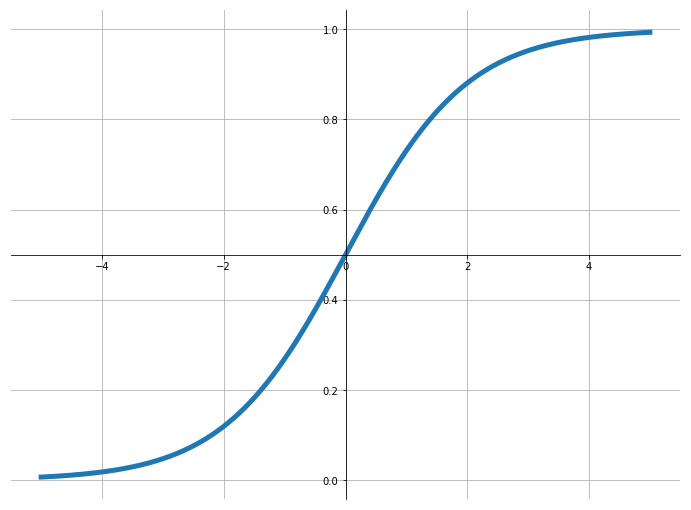

In [10]:
plot(x, 1/(1 + np.exp(-x)))

$$
f(x) = \max(0, x)
$$

In [11]:
plot(x, np.maximum(x, 0))

## Нейронные сети

<center>
    <img src="../img/net.png">
</center>

## Многослойная сеть

Введем ряд обозначений:
* $n = 1, \dotsc, N$ - номер слоя
* $j = 0, \dotsc, J_n$ - нумерация нейронов внутри слоя, при этом $(j=0)$ будет соответстовать фиктивному нейрону, который всегда выдает 1.
* $x_j$, $\vec{x}$ - входные данные (признаки) 
* $y_j^{(n)}$, $\vec{y}^{(n)}$ - вывод $j$-го нейрона в $n$-ом слое. $y_j^{(0)} = x_j$.
* $f_j^{(n)}$ - функция активации $j$-го нейрона в $n$-ом слое, для простоты будем считать, что для всех нейронов они одинаковы
* $z_j^{(n)}$ - результат суммирования $j$-го нейрона в $n$-ом слое

$$
z_j^{(n)} = \sum_{i=0}^{I_n} \omega_{ij}^{(n)} y^{(n-1)}_i = (\vec{\omega}^{(n)}_j)^T \vec{y}^{(n-1)}
$$

$$
y_j^{(n)} = f_j^{(n)}(z_j^{(n)})
$$

А если ввести матрицу $\mathbf{W}^{(n)}$, в строках которой написаны веса нейронов для слоя $(n)$, то можно записать эти формулы даже проще

$$
\textbf{W}^{(n)} = (\vec{\omega}^{(n)}_1,\vec{\omega}^{(n)}_2, \dotsc, \vec{\omega}^{(n)}_J)^T
$$

$$
\vec{z}^{(n)} = \mathbf{W}^{(n)} \vec{y}^{(n-1)}
$$

$$
\vec{y}^{(n)} = f^{(n)}(\vec{z}^{(n)})
$$

$$
f^{(n)}(\vec{z}^{(n)}) = \left[\begin{align}
f_1^{(n)}(z_1^{(n)})
\\
f_2^{(n)}(z_2^{(n)})
\\
\dotsc
\\
f_J^{(n)}(z_J^{(n)})
\end{align}\right]
$$

## Задачка

Пусть у нас есть набор примеров рукописного текста (числа). Нам нужно придумать нейронную сеть, которая будет распознавать отдельные числа.

In [15]:
from sklearn.datasets import fetch_openml

# https://www.openml.org/d/554
# Это займет умеренно существенно время, пока данные скачаются
# MNIST_X, MNIST_y = fetch_openml('mnist_784', version=1, return_X_y=True)

import pickle

f = open("../data/mnist.pkl3", "rb")
MNIST_X = pickle.load(f)
MNIST_y = pickle.load(f)

In [16]:
MNIST_X.shape, MNIST_y.shape

((2000, 784), (2000,))

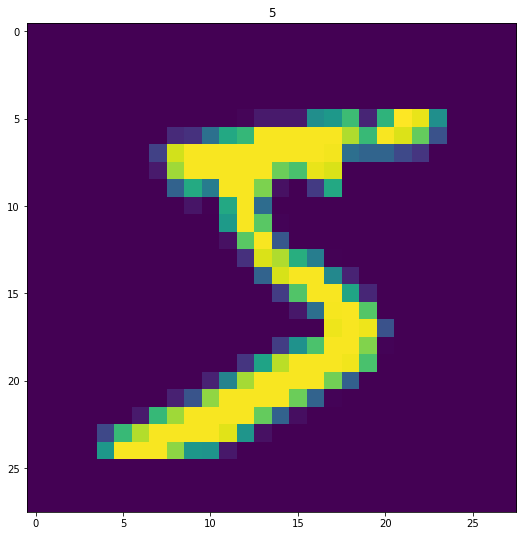

In [17]:
plt.imshow(MNIST_X[0].reshape((28, 28)))
plt.title("%s" % MNIST_y[0])
plt.show()

In [18]:
MNIST_X.min(), MNIST_X.max()

(0.0, 255.0)

In [19]:
print(MNIST_y)

['5' '0' '4' ... '5' '2' '0']


**Входные данные:** изображение, значения пикселей, нормированные на интервал $[0,1]$.


**Выход:** вектор принадлежности к соответствующему классу

Функция активации:

$$
f(x) = \frac{1}{1 + e^{-x}}
$$

<center>
    <img src="../img/net10.png">
<center>

При создании сети, как лучше всего инициализировать веса?

In [20]:
def plot(clf, X, y):        
    x_max, x_min = X[:, 0].max(), X[:, 0].min()
    y_max, y_min = X[:, 1].max(), X[:, 1].min()
    
    dx = (x_max - x_min) * 0.1    
    dy = (y_max - y_min) * 0.1
    
    xx, yy = np.meshgrid(np.linspace(x_min - dx, x_max + dx, 100),
                         np.linspace(y_min - dy, y_max + dy, 100))
    
    Z = np.zeros(xx.size)
    
    Z = clf.predict(np.vstack([xx.ravel(), yy.ravel()]).T).ravel()
        
    plt.pcolormesh(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.Wistia)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.get_cmap("Wistia"), 
                edgecolors='k', s=50)

In [21]:
class Net:
    def __init__(self, layers, random_state=None):
        self.layers = layers.copy()
        self.random_state = random_state
        self.classes = None # Сюда мы будет кодировать классы
        self.Ws = [None,] # 
            
    def _f(self, z):
        """
            Наша функция активации
        """
        return 1.0 / (1.0 + np.exp(-z))
                        
    def _forward(self, x):
        """
            Вычисление вывода каждого слоя
        """
        x = x.reshape((-1, 1))
        yn = [x,] # вывод нулевого слоя
        for w in self.Ws[1:]:
            x = np.vstack([1, x]) # добавляем сигнал фиктивного нейрона
            x = self._f(w @ x)
            yn.append(x)
        return yn
    
    def _to_dummy(self, y):
        """
            Перевод класса в dummy переменную
        """
        return (self.classes == y).astype('int')
    
    def _predict_proba(self, x):
        yn = self._forward(x)
        return yn[-1].ravel()

    def fit(self, X, y):
        """
            X - массив прецедентов
            y - метки классов (обязательна числа)
        """
        np.random.seed(self.random_state)
        
        self.classes = np.sort(np.unique(y))                
        self.Ws = [None,]
        layers = [X.shape[1]] + self.layers + [self.classes.size]

        for n in range(1, len(layers)):
            Jn = layers[n]
            Jn_1 = layers[n-1]
            # +1 из-за добавки фиктивного нейрона
            self.Ws.append(np.random.normal(0, 1, size=(Jn, Jn_1 + 1)))
    
    def predict_proba(self, X):
        result = []
        for x in X:
            result.append(self._predict_proba(x))
        return np.array(result)
    
    def predict(self, X):
        result = []
        for x in X:
            y = np.argmax(self._predict_proba(x))
            result.append(y)
        return np.array(result)

L before =  0.6207646022569916
L after =  0.6207646022569916


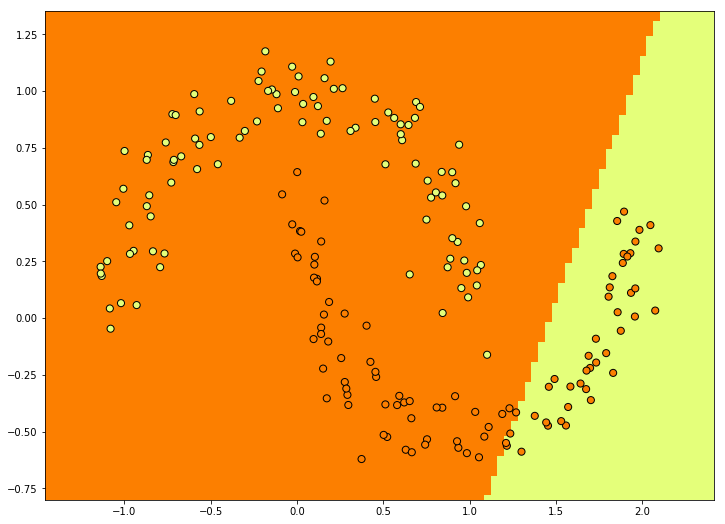

In [63]:
from sklearn.datasets import make_blobs, make_moons

#X, y = make_blobs(200, centers=2, random_state=15, center_box=(-2, 2))
X, y = make_moons(200, noise=0.1, random_state=13)

net = Net([5])
net.fit(X, y)
plot(net, X, y)

## Обучение

Как же можно обучать нейронную сеть?

Необходимо завести функцию потерь, отображающую качество классификации и воспользоваться любым способом её минимизации. 

Мы будем пользоваться градиентным спуском.

## Градиентный спуск

Тут всё довольно просто, мы выбираем функцию потерь в виде

$$
L = \frac{1}{M} \sum_{m=1}^{M} \mathcal{L}_m
$$

Находим производную по весам и просто движемся в обратную сторону от направления градиента

$$
\tilde{\omega}_{ij}^{(n)} = 
\omega_{ij}^{(n)} - 
\frac{
    \partial L
}{
    \partial \omega_{ij}^{(n)}
}
=
\omega_{ij}^{(n)} - 
\frac{1}{M}\sum_m
\frac{
    \partial \mathcal{L}_m
}{
    \partial \omega_{ij}^{(n)}
}
$$

## Стохастический градиентный спуск

Для довольно больших объемов данных порой удобнее использовать стохастический градиентный спуск, для которого один шаг оптимизации выглядит следующим образом

$$
\tilde{\omega}_{ij}^{(n)} = 
\omega_{ij}^{(n)} - 
\frac{
    \partial \mathcal{L}_m
}{
    \partial \omega_{ij}^{(n)}
}
$$

## Функции потерь

* квадратичная ошибка (mse)

$$
\mathcal{L} = \frac{1}{2} (y - \tilde{y})^2
$$

* абсолютная ошибка (mae)

$$
\mathcal{L} = |y - \tilde{y}|
$$

* logloss

$$
\mathcal{L} = -y \ln \tilde{y} - (1-y) \ln (1 - \tilde{y})
$$

## Метод обратного распространения ошибки

Мы выбрали функцию потерь

$$
\mathcal{L} = \frac{1}{2} (y - \tilde{y})^2
$$

и теперь нам нужно лишь найти все производные

$$
\frac{
    \partial \mathcal{L}
}{
    \partial \omega_{ij}^{(n)}
}
$$

Рассмотрим обычное взятие производной сложной функции

$$
\frac{\partial \mathcal{L}}{\partial \omega^{(n)}_{ij}} 
= 
\frac{\partial \mathcal{L}}{\partial z^{(n)}_{j}}
\frac{\partial z^{(n)}_{j}}{\partial \omega^{(n)}_{ij}} 
=
\frac{\partial \mathcal{L}}{\partial z^{(n)}_{j}}
y^{(n-1)}_i
$$

где

$$
\frac{\partial z^{(n)}_{j}}{\partial \omega^{(n)}_{ij}} 
= 
\frac{
    \partial (\sum_i \omega_{ij}^{(n)} y_i^{(n-1)})
}{\partial \omega^{(n)}_{ij}} 
=
y_i^{(n-1)}
$$

Обозначим 

$$
\delta_j^{(n)} = \frac{\partial \mathcal{L}}{\partial z^{(n)}_{j}}
$$

$$
\vec{\delta}^{(n)} = \frac{\partial L}{\partial \vec{z}^{(n)}}
$$

Теперь можем записать производную немного проще

$$
\frac{\partial \mathcal{L}}{\partial \vec{\omega}^{(n)}_{j}} 
= 
{\delta}^{(n)}_j
\vec{y}^{(n-1)}
$$

Или совсем просто

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W}^{(n)}} 
= 
\vec{\delta}^{(n)}
(\vec{y}^{(n-1)})^T
$$

$$
\tilde{\mathbf{W}}^{(n)} = \mathbf{W}^{(n)} - \vec{\delta}^{(n)}
(\vec{y}^{(n-1)})^T
$$

Уже значительно лучше, но нам всё ещё нужно найти $\vec{\delta}^{(n)}$

$$
\delta_j^{(n)} 
= 
\frac{\partial \mathcal{L}}{\partial z^{(n)}_{j}} 
= 
\frac{\partial \mathcal{L}}{\partial y^{(n)}_{j}}
\frac{\partial y^{(n)}}{\partial z^{(n)}_{j}}
=
\frac{\partial \mathcal{L}}{\partial y^{(n)}_{j}}
f'(z^{(n)}_{j})
$$

где

$$
y = f(z)
$$

Немного отойдем назад и вспомним, где же $y_j^{(n)}$ встречается в нашей задаче

$$
\mathcal{L}(y^{(n+1)}_1, \dotsc, y^{(n+1)}_J)
$$

где $y^{(n+1)}_j$ является функций $\vec{y}^{(n)}$

$$
\delta_j^{(n)} 
=
f'(z^{(n)}_{j})
\sum_{k=1}^{J_{n+1}}
\left[
    \frac{\partial L}{\partial y^{(n+1)}_{k}}
    \frac{\partial y^{(n+1)}_{k}}{\partial z^{(n+1)}_{k}}
    \frac{\partial z^{(n+1)}_{k}}{\partial y^{(n)}_{j}}
\right]
=\\
=
f'(z^{(n)}_{j})
\sum_{k=1}^{J_{n+1}}
\left[
    \frac{\partial L}{\partial y^{(n+1)}_{k}}
    f'(z^{(n+1)}_{k})
    \omega_{jk}^{(n+1)}
\right]
$$

где 

$$
\frac{\partial z^{(n+1)}_{k}}{\partial y^{(n)}_{j}}
= 
\frac{
    \partial (\sum_i \omega_{ik}^{(n+1)} y_j^{(n)})
}{\partial y^{(n)}_{j}} 
=
\omega_{jk}^{(n+1)}
$$

$$
\delta_j^{(n)} 
=
\frac{\partial \mathcal{L}}{\partial y^{(n)}_{j}}
f'(z^{(n)}_{j})
$$

$$
\delta_j^{(n)} 
=
f'(z^{(n)}_{j})
\sum_{k=1}^{J_{n+1}}
\left[
    \frac{\partial L}{\partial y^{(n+1)}_{k}}
    f'(z^{(n+1)}_{k})
    \omega_{jk}^{(n+1)}
\right]
$$

Общее выражение для $\delta$

$$
\delta_j^{(n)} = f'(z^{(n)}_{j})
\sum_{k=1}^{J_{n+1}}
\left[
    \delta_k^{(n+1)}
    \omega_{jk}^{(n+1)}
\right]
$$

таким образом, мы можем расчитать все $\delta$ зная лишь $\delta^{(N)}$

Давайте мы его найдем

$$
\delta_j^{(N)} 
=
\frac{\partial \mathcal{L}}{\partial y^{(N)}_{j}}
f'(z^{(N)}_{j})
=\\
=(y^{(N)}_j - y_j) y^{(N)}_j (1 - y^{(N)}_j)
$$

где

$$
f'(z) = \left( \frac{1}{1+e^{-z}} \right)'
= \frac{e^{-z}}{(1+e^{-z})^2} = \\
=
\frac{1}{1+e^{-z}} \left(
1 - \frac{1}{1+e^{-z}}
\right) = f(z) (1 - f(z)) = y (1 - y)
$$

Введем новое обозначение (произведение Адамара), такое что

$$
(\mathbf{A} \circ \mathbf{B})_{i,j} = (A)_{i,j} \cdot (B)_{i,j}
$$

то есть мы просто по компонентно перемножаем элементы матриц

С этим обозначением наши выражения можно записать как

$$
\vec{\delta}^{(N)} = \vec{y}^{(N)} \circ (\vec{1} - \vec{y}^{(N)})
\circ  (\vec{y}^{(N)} - \vec{y}) 
$$

$$
\vec{\delta}^{(n)} = \vec{y}^{(N)} \circ (\vec{1} - \vec{y}^{(N)}) \circ
( (\mathbf{W}^{(n+1)})^T \vec{\delta}^{(n+1)} )
$$

$$
\tilde{\mathbf{W}}^{(n)} = \mathbf{W}^{(n)} - \vec{\delta}^{(n)}
(\vec{y}^{(n-1)})^T
$$

## Batch

Для полного или частичного градиента просто добавиться усреднение по всем входным значениям.

## Алгоритм

Теперь мы готовы описать алгоритм обратного распространения ошибки:

1. Проинициализировать сеть небольшими случайными значениями
2. Для входных параметров мы расчитываем значение выводов каждого слоя $\vec{y}^{(n)}$ (forward)
3. Рассчитываем ошибку $\vec{\delta}^{(N)}$ и затем от последнего слоя к первому расчитываем остальные $\vec{\delta}^{(n)}$ (backpropagation)
4. Корректируем веса $\mathbf{W}^{(n)}$
5. Перейти к шагу 2

In [108]:
class MSENet(Net):   
    def _loss(self, X, y):
        """
            Функция потерь
        """
        result = 0        
        for xv, yv in zip(X, y):
            dummy = self._to_dummy(yv)
            yp = self._forward(xv)[-1].ravel()
            result += np.sum( (yp - dummy)**2 )
        return result / X.shape[0]
    
    def _fit(self, x, yt):
        x = x.reshape((-1, 1))
        yt = yt.reshape((-1, 1))        
        yn = self._forward(x)
        
        delta = [None for _ in self.Ws]
        delta[-1] = yn[-1] * (1 - yn[-1]) * (yn[-1] - yt)
        
        N = len(self.Ws) - 1
        
        for n in range(N-1, 0, -1):
            tmp = self.Ws[n+1].T @ delta[n+1]
            # А теперь небольшая расплата за то, что у нас
            # на самом деле нет фиктивного нейрона в предыдущем слое
            # поэтому delta[0] мы выкидываем (оно все-равно всегда 0)
            tmp = tmp[1:]
            delta[n] = yn[n] * (1 - yn[n]) * tmp
        
        # Теперь меняем веса
        dWs = [None,]
        for n in range(1, len(self.Ws)):
            yy = np.vstack([1, yn[n-1]])
            dWs.append(delta[n] * yy.T)        
        return dWs
        
    def fit(self, X, y, iterations=1, verbose=0):
        """
            X - массив прецедентов
            y - метки классов (обязательна числа)
        """
        np.random.seed(self.random_state)    
        
        self.classes = np.sort(np.unique(y))        
        self.Ws = [None,]
        layers = [X.shape[1]] + self.layers + [self.classes.size]

        for n in range(1, len(layers)):
            Jn = layers[n]
            Jn_1 = layers[n-1]
            # +1 из-за добавки фиктивного нейрона
            self.Ws.append(np.random.normal(0, 1, size=(Jn, Jn_1 + 1)))
                    
        if verbose > 0:
            Lb = self._loss(X, y)
            print("L before = ", Lb)
        
        for step in range(iterations):
            idx = np.random.choice(X.shape[0])
                
            dW = [None, ]
            for w in self.Ws[1:]:
                dW.append(np.zeros(w.shape))

            
            tmp = self._fit(X[idx], self._to_dummy(y[idx]))
            for n in range(1, len(layers)):
                dW[n] += tmp[n]

            for n in range(1, len(layers)):
                self.Ws[n] -= dW[n]
            
            if verbose > 1:
                L = self._loss(X, y)
                print("L #%5d = " % step, L)
                
        if verbose > 0:
            La = self._loss(X, y)
            print("L after = ", La)    

In [116]:
%%time

from sklearn.datasets import make_blobs, make_moons

#X, y = make_blobs(200, centers=2, random_state=15, center_box=(-2, 2))
X, y = make_moons(200, noise=0.1, random_state=13)

net = MSENet([3,], random_state=13)
net.fit(X, y, iterations=100000, verbose=1)

L before =  0.5981571803705672
L after =  0.0002686557636542845
CPU times: user 10.8 s, sys: 4.3 ms, total: 10.8 s
Wall time: 10.8 s


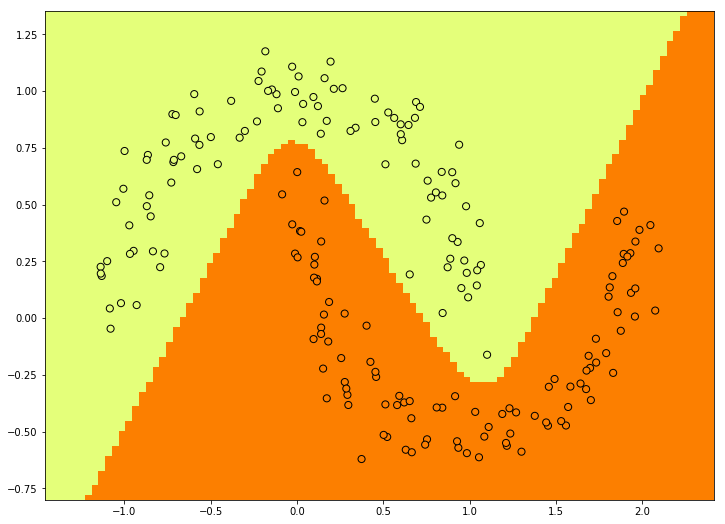

In [118]:
plot(net, X, y)

## Распознавание чисел

In [191]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

f = open("../data/mnist.pkl3", "rb")
MNIST_X = pickle.load(f)
MNIST_y = pickle.load(f)
f.close() 

MNIST_X = MNIST_X / 255
MNIST_y = np.array(list(map(int, MNIST_y)))
X_t, X_v, y_t, y_v = train_test_split(MNIST_X, MNIST_y, random_state=42)

In [192]:
%%time

net = MSENet([15], random_state=42)
net.fit(X_t, y_t, iterations=100000, verbose=1)
y_p = net.predict(X_v)

print("Accuracy =", accuracy_score(y_v, y_p))

L before =  2.5675815243274642
L after =  0.03636425156759531
Accuracy = 0.858
CPU times: user 15.9 s, sys: 552 µs, total: 15.9 s
Wall time: 15.9 s


Давайте теперь попробуем другую функцию потерь.

Функция потерь для многоклассовой классификации

$$
\mathcal{L} = - \sum_j  \left[
    y_j \ln \tilde{y}_j + (1 - y_j) \ln (1 - \tilde{y}_j)
\right]
$$

$$
\delta_j^{(N)} 
=
\frac{\partial \mathcal{L}}{\partial y^{(N)}_{j}}
f'(z^{(N)}_{j})
=\\
=(y^{(N)}_j - y_j)
$$


In [186]:
class LoglossNet(Net):
    def _loss(self, X, y):
        """
            Функция потерь
        """
        result = 0        
        for xv, yv in zip(X, y):
            dummy = self._to_dummy(yv)
            yp = self._forward(xv)[-1].ravel()
            for yyp, yyv in zip(yp, dummy):
                if yyv == 0:
                    result += -np.log(1-yyp)
                else:
                    result += -np.log(yyp)
        return result / X.shape[0]                        
    
    def _fit(self, x, yt):
        x = x.reshape((-1, 1))
        yt = yt.reshape((-1, 1))        
        yn = self._forward(x)
        
        delta = [None for _ in self.Ws]
        delta[-1] = (yn[-1] - yt)
        
        N = len(self.Ws) - 1
        
        for n in range(N-1, 0, -1):
            tmp = self.Ws[n+1].T @ delta[n+1]
            # А теперь небольшая расплата за то, что у нас
            # на самом деле нет фиктивного нейрона в предыдущем слое
            # поэтому delta[0] мы выкидываем (оно все-равно всегда 0)
            tmp = tmp[1:]
            delta[n] = yn[n] * (1 - yn[n]) * tmp
        
        # Теперь меняем веса
        dWs = [None,]
        for n in range(1, len(self.Ws)):
            yy = np.vstack([1, yn[n-1]])
            dWs.append(delta[n] * yy.T)        
        return dWs

    def fit(self, X, y, batch=1, epoch=1, verbose=0):
        """
            X - массив прецедентов
            y - метки классов (обязательна числа)
        """
        np.random.seed(self.random_state)    
        
        self.classes = np.sort(np.unique(y))        
        self.Ws = [None,]
        layers = [X.shape[1]] + self.layers + [self.classes.size]

        for n in range(1, len(layers)):
            Jn = layers[n]
            Jn_1 = layers[n-1]
            # +1 из-за добавки фиктивного нейрона
            self.Ws.append(np.random.normal(0, 1, size=(Jn, Jn_1 + 1)))
                    
        if verbose > 0:
            Lb = self._loss(X, y)
            print("L before = ", Lb)
        
        for step in range(epoch):
            idxs = []
            
            if batch is None:
                # Если не нужно использовать данные мелкими кусочками
                idxs = [np.arange(0, X.shape[0])]
            else:
                # перемешиваем индексы
                tmp = np.arange(0, X.shape[0])
                np.random.shuffle(tmp)
                # и добавляем их в массив
                for n in range(0, X.shape[0], batch):
                    idxs.append(tmp[n:n+batch])
            
            for idx in idxs:
                dW = [None, ]
                for w in self.Ws[1:]:
                    dW.append(np.zeros(w.shape))

                for i in idx:                
                    tmp = self._fit(X[i], self._to_dummy(y[i]))
                    for n in range(1, len(layers)):
                        dW[n] += tmp[n]

                for n in range(1, len(layers)):
                    self.Ws[n] -= 3 * dW[n] / idx.size
            
            if verbose > 1:
                L = self._loss(X, y)
                print("L #%5d = " % step, L)
                
        if verbose > 0:
            La = self._loss(X, y)
            print("L after = ", La)    

In [185]:
%%time

X, y = make_moons(200, noise=0.1, random_state=13)
net = LoglossNet([3,])
net.fit(X, y, epoch=500, batch=10, verbose=1)

L before =  1.386610580603628
L after =  0.00413024322524395
CPU times: user 8.17 s, sys: 112 µs, total: 8.17 s
Wall time: 8.2 s


In [187]:
plot(net, X, y)

In [188]:
%%time

net = LoglossNet([30], random_state=42)
net.fit(X_t, y_t, epoch=100, batch=10, verbose=1)
y_p = net.predict(X_v)

print("Accuracy =", accuracy_score(y_v, y_p))

L before =  9.642141433125543
L after =  0.01506787761574082
Accuracy = 0.864
CPU times: user 1min 13s, sys: 12.6 ms, total: 1min 13s
Wall time: 1min 13s


## Плюсы Backpropagation

* быстро вычисляется
* легко обобщается на любые функции активации, функции потерь и число слоев
* возможность online-обучения
* легко распараллеливается

## Проблемы Backpropagation

* сходимость не всегда хорошая
* локальные минимумы
* взрыв градиента
* паралич сети
* переобучение

## Softmax

В предыдущем случае всё получилось отлично, т.к. мы взяли специфическую функцию потерь и функцию активации, но что если у нас функция активации не ограничена?

Мы можем получить тогда произвольное значение целевого признака.

Нам бы хотелось получить на выходах нейронной сети нечто, что было бы очень похоже на вероятности

Идея в том, чтобы заменить последний слой нейронов, отвечающих за выход, специфический softmax-слоем.

$$
z_j^{(N)} = \sum_i \omega^{(N)}_{ij} y_i^{(N-1)}
$$

$$
y_j^{(N)} = \frac{
    e^{z_j^{(N)}}
}{
    \sum_k e^{z_k^{(N)}}
}
$$

В этом случае

$$
\sum_j y_j^{(N)} = 1
$$

## Регуляризация

При обучении, у нас нет никаких ограничений на веса, что может приводить к печальным последствиям.

$$
L = \frac{1}{M} \sum_m \mathcal{L}_m + \lambda \frac{1}{M} \sum_m \mathcal{R}_m
$$

## L2-регуляризация

Самый простой вариант регуляризации - это просто сумма квадратов всех весов модели
$$
\mathcal{R} = \sum_n \sum_i \sum_j (\omega^{(n)}_{ij})^2
$$

$$
\tilde{\mathbf{W}}^{(n)} = (1 - \lambda) \mathbf{W}^{(n)} - \vec{\delta}^{(n)}
(\vec{y}^{(n-1)})^T
$$

## Dropout

Довольно интересной техникой по борьбе с переобучением сети является метод случайного отключения нейронов.

Во время обучения(и только во время его), мы просто отключаем нейроны с некоторой вероятностью. Это эквивалентно тому, что мы просто умножаем $\vec{y}$ на некоторый вектор случайных величин $\vec{d}$.

При этом $d_j = 0$ с вероятностью $p$ и $d_j = 1$ с  вероятностью $q = 1-p$.

Во время обучения у нас ничего не меняется (кроме домножения на случайный вектор)

$$
\vec{y}^{(n)} = \vec{d}^{(n)} \circ f(\vec{z}^{(n)})
$$

а вот во время нормальной работы сети из-за того, что в слое во время обучения было меньше нейронов, нужно отмасштабировать вход

$$
\vec{y}^{(n)} = q f(\vec{z}^{(n)})
$$

На практике обычно используют обратные значения, масштабируя значения во время обучения и не меняя значения во время работы сети

во время обучения

$$
\vec{y}^{(n)} = \frac{1}{q} \vec{d}^{(n)} \circ f(\vec{z}^{(n)})
$$

во время работы

$$
\vec{y}^{(n)} =f(\vec{z}^{(n)})
$$

## sklearn

В sklearn уже реализована простейшая многослойная нейронная сеть с поддержкой регуляризации и различных видов функций активации

* __[MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__
* __[MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)__

In [193]:
%%time
from sklearn.neural_network import MLPClassifier

net = MLPClassifier([30], activation='logistic', solver='adam', tol=0.0001, max_iter=200,
                    random_state=42)

net.fit(X_t, y_t)
y_p = net.predict(X_v)

print("Accuracy =", accuracy_score(y_v, y_p))

Accuracy = 0.884
CPU times: user 3.86 s, sys: 15.7 ms, total: 3.87 s
Wall time: 3.88 s


In [196]:
net = MLPClassifier([50], activation='logistic', 
                    warm_start=True, alpha=0, max_iter=1,
                    solver='adam', tol=1e-12,random_state=42)

x = np.arange(1, 2000, 1)
y = []
y2 = []

for step in x:
    net.fit(X_t, y_t)
    
    y_p = net.predict(X_v)
    y.append(accuracy_score(y_v, y_p))
    
    y2_p = net.predict(X_t)
    y2.append(accuracy_score(y_t, y2_p))
    
    #print("X = %6d, Acc = %.5f (%.5f)" % (step, y[-1], y2[-1])) 

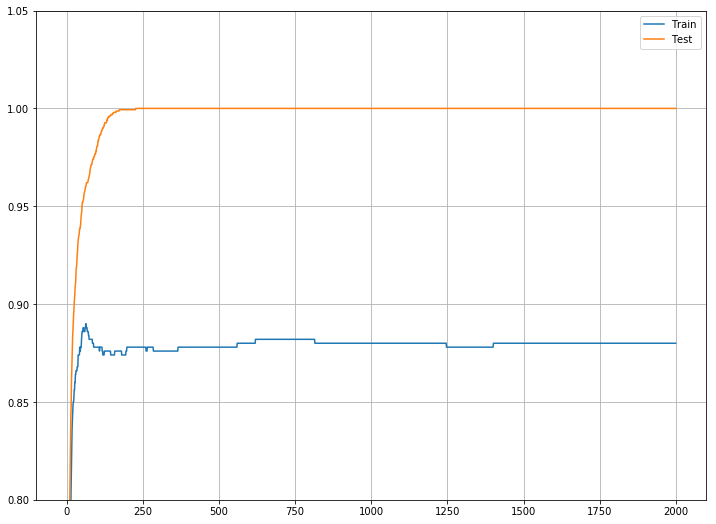

In [197]:
plt.ylim([0.8, 1.05])
plt.plot(x, y, label="Train")
plt.plot(x, y2, label="Test")
plt.grid()
plt.legend()